In [1]:
import os
import cv2
import math
import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, GlobalAvgPool2D, GlobalMaxPool2D
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.utils import plot_model

from keras.utils import np_utils

In [2]:
INPUT_PATH = r"FER13_Cleaned_Dataset" # Dataset: https://www.kaggle.com/datasets/gauravsharma99/fer13-cleaned-dataset

In [3]:
total_images = 0
for dir_ in os.listdir(INPUT_PATH):
    count = 0
    for f in os.listdir(INPUT_PATH + dir_ + "/"):
        count += 1
        total_images += 1
    print(f"{dir_} has {count} number of images")
    
print(f"\ntotal images are {total_images}")

Angry has 2832 number of images
disgust has 380 number of images
fear has 2535 number of images
Happy has 6834 number of images
Neutral has 4295 number of images

total images are 16876


In [4]:
TOP_EMOTIONS = ["fear", "Happy", "Neutral", "Angry"]
total_images -= 380
total_images

16496

In [5]:
img_arr = np.empty(shape=(total_images,48,48,3))
img_label = np.empty(shape=(total_images))
label_to_text = {}

i = 0
e = 0
for dir_ in os.listdir(INPUT_PATH):
    if dir_ in TOP_EMOTIONS:
        label_to_text[e] = dir_
        for f in os.listdir(INPUT_PATH + dir_ + "/"):
            img_arr[i] = cv2.imread(INPUT_PATH + dir_ + "/" + f)
            img_label[i] = e
            i += 1
        print(f"loaded all {dir_} images to numpy arrays")
        e += 1

img_arr.shape, img_label

loaded all Angry images to numpy arrays
loaded all fear images to numpy arrays
loaded all Happy images to numpy arrays
loaded all Neutral images to numpy arrays


((16496, 48, 48, 3), array([0., 0., 0., ..., 3., 3., 3.]))

In [6]:
label_to_text

{0: 'Angry', 1: 'fear', 2: 'Happy', 3: 'Neutral'}

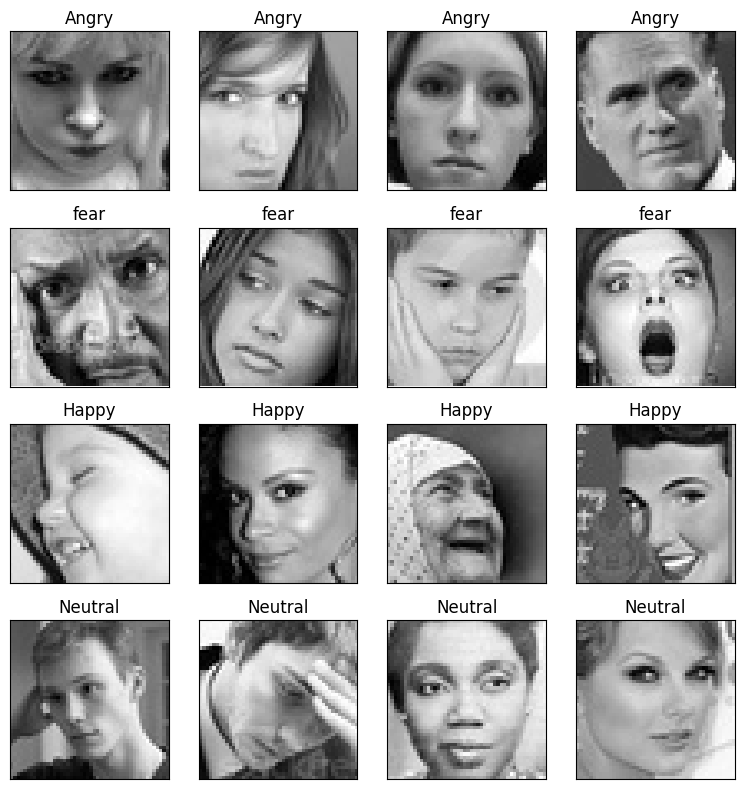

In [7]:
fig = pyplot.figure(1, (8,8))

idx = 0
for k in label_to_text:
    sample_indices = np.random.choice(np.where(img_label==k)[0], size=4, replace=False)
    sample_images = img_arr[sample_indices]
    for img in sample_images:
        idx += 1
        ax = pyplot.subplot(4,4,idx)
        ax.imshow(img[:,:,0], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(label_to_text[k])
        pyplot.tight_layout()

In [8]:
img_label = np_utils.to_categorical(img_label)
img_label.shape

(16496, 4)

In [9]:
img_arr = img_arr / 255.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(img_arr, img_label,
                                                    shuffle=True, stratify=img_label,
                                                    train_size=0.9, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((14846, 48, 48, 3), (1650, 48, 48, 3), (14846, 4), (1650, 4))

In [11]:
del img_arr
del img_label

In [12]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

In [14]:
from tensorflow.keras.regularizers import l2

mobile_net = MobileNet(
    input_shape = (img_width, img_height, img_depth),
    include_top = False,
    weights = "imagenet",
    classes = num_classes
)

x = mobile_net.layers[-14].output
global_pool = GlobalMaxPool2D(name="global_pool")(x)
# out = Dense(num_classes, activation="softmax", name="out_layer")(global_pool)
out = Dense(num_classes, activation="softmax", name="out_layer", kernel_regularizer=l2(0.001))(global_pool) # With L2

model = Model(inputs=mobile_net.input, outputs=out)

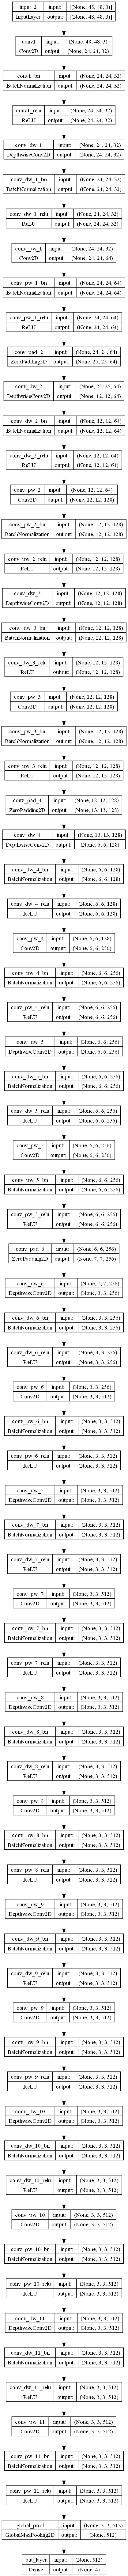

In [15]:
# Visualize the model architecture
plot_model(model, to_file='mobilenet_architecture.png', show_shapes=True, show_layer_names=True)

In [16]:
# Print model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 conv1 (Conv2D)              (None, 24, 24, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 24, 24, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 24, 24, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 24, 24, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 24, 24, 32)       128       
 ation)                                                      

In [17]:
for layer in model.layers[:15]:
    layer.trainable = False

In [18]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    zca_whitening=False,
)
train_datagen.fit(X_train)

In [19]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00008,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    min_delta=0.0001,
    factor=0.25,
    patience=4,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [20]:
batch_size = 25
epochs = 40

optims = [
    optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    optimizers.Adam(0.01),
]

model.compile(
        loss='categorical_crossentropy',
        optimizer=optims[1],
        metrics=['accuracy']
)

history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_test, y_test),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/40
593/593 [==============================] - 20s 26ms/step - loss: 1.2687 - accuracy: 0.5046 - val_loss: 2.3483 - val_accuracy: 0.1933 - lr: 0.0100
Epoch 2/40
593/593 [==============================] - 14s 24ms/step - loss: 0.9918 - accuracy: 0.5998 - val_loss: 1.0384 - val_accuracy: 0.5861 - lr: 0.0100
Epoch 3/40
593/593 [==============================] - 14s 24ms/step - loss: 0.9182 - accuracy: 0.6349 - val_loss: 1.0528 - val_accuracy: 0.5545 - lr: 0.0100
Epoch 4/40
593/593 [==============================] - 14s 23ms/step - loss: 0.8645 - accuracy: 0.6534 - val_loss: 0.9101 - val_accuracy: 0.6455 - lr: 0.0100
Epoch 5/40
593/593 [==============================] - 15s 24ms/step - loss: 0.8410 - accuracy: 0.6626 - val_loss: 1.0093 - val_accuracy: 0.5727 - lr: 0.0100
Epoch 6/40
593/593 [==============================] - 14s 24ms/step - loss: 0.8202 - accuracy: 0.6778 - val_loss: 0.9089 - val_accuracy: 0.6624 - lr: 0.0100
Epoch 7/40
593/593 [==============================] - 15s 

In [21]:
# Save the model's architecture to a JSON string
model_json = model.to_json()
with open("model_mobilenet_l2.json", "w") as json_file:
    json_file.write(model_json)

# Save the weights to a HDF5 file
model.save("model_mobilenet_l2.h5")

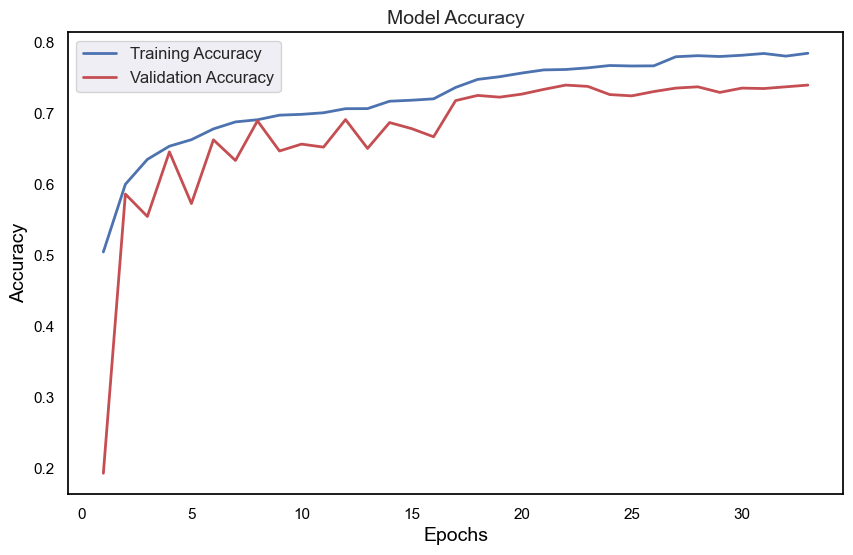

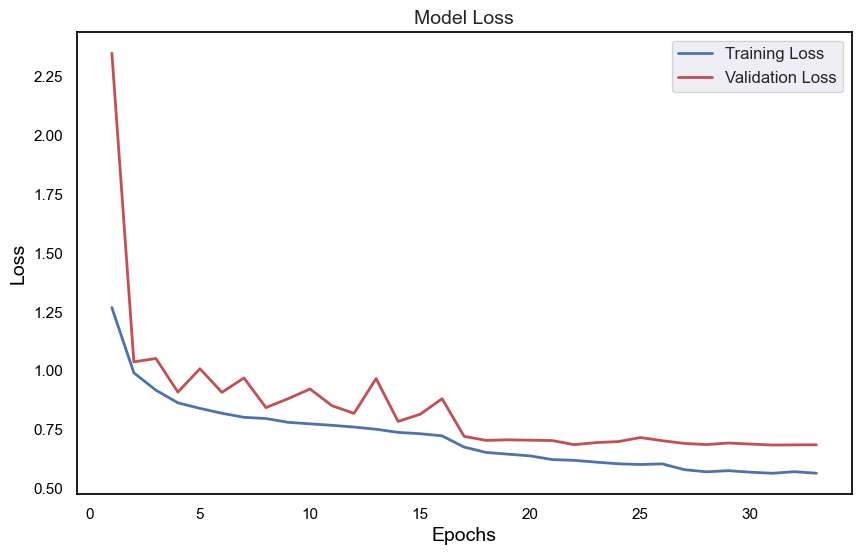

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set Seaborn style
sns.set()

# Assuming you have 'history' from model.fit()
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Define the number of epochs based on the length of the training loss list
epochs = range(1, len(train_loss) + 1)

# Plot the train and validation accuracy
plt.figure(figsize=(10, 6), facecolor='white')  # Set the figure background to white
ax = plt.gca()  # Get current axis
ax.set_facecolor('white')  # Set the axis background to white

# Ensure axis lines and labels are visible
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['right'].set_color('black')
ax.xaxis.label.set_color('black')
ax.yaxis.label.set_color('black')
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')

# Plot the training and validation accuracy
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy', linewidth=2, markersize=6)
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy', linewidth=2, markersize=6)
plt.title('Model Accuracy', fontsize=14)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(fontsize=12)

# Save the accuracy plot
plt.savefig('mobilenet_accuracy_l2.png', dpi=300)  # Save with higher DPI
plt.show()

# Plot the train and validation loss
plt.figure(figsize=(10, 6), facecolor='white')  # Set the figure background to white
ax = plt.gca()  # Get current axis
ax.set_facecolor('white')  # Set the axis background to white

# Ensure axis lines and labels are visible
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['right'].set_color('black')
ax.xaxis.label.set_color('black')
ax.yaxis.label.set_color('black')
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')

# Plot the training and validation loss
plt.plot(epochs, train_loss, 'b-', label='Training Loss', linewidth=2, markersize=6)
plt.plot(epochs, val_loss, 'r-', label='Validation Loss', linewidth=2, markersize=6)
plt.title('Model Loss', fontsize=14)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=12)

# Save the loss plot
plt.savefig('mobilenet_loss_l2.png', dpi=300)  # Save with higher DPI
plt.show()

In [34]:
label_to_text

[0, 1, 2, 3, 'Fear']

In [ ]:
text_to_label = dict((v,k) for k,v in label_to_text.items())
text_to_label

In [29]:
# Original dictionary
text_to_label = {'Angry': 0, 'Fear': 1, 'Happy': 2, 'Neutral': 3}

# Updating the label 'fear' to 'Fear'
#text_to_label['Fear'] = text_to_label.pop('fear')

# The updated dictionary
print(text_to_label)

{'Angry': 0, 'Fear': 1, 'Happy': 2, 'Neutral': 3}


52/52 [==============================] - 0s 9ms/step
Classification Report:
              precision    recall  f1-score   support

       Angry     0.6013    0.6396    0.6199       283
        Fear     0.6611    0.4704    0.5497       253
       Happy     0.8906    0.8684    0.8793       684
     Neutral     0.6494    0.7581    0.6996       430

    accuracy                         0.7394      1650
   macro avg     0.7006    0.6841    0.6871      1650
weighted avg     0.7429    0.7394    0.7374      1650

Confusion Matrix:
[[181  18  15  69]
 [ 63 119  18  53]
 [ 21  15 594  54]
 [ 36  28  40 326]]


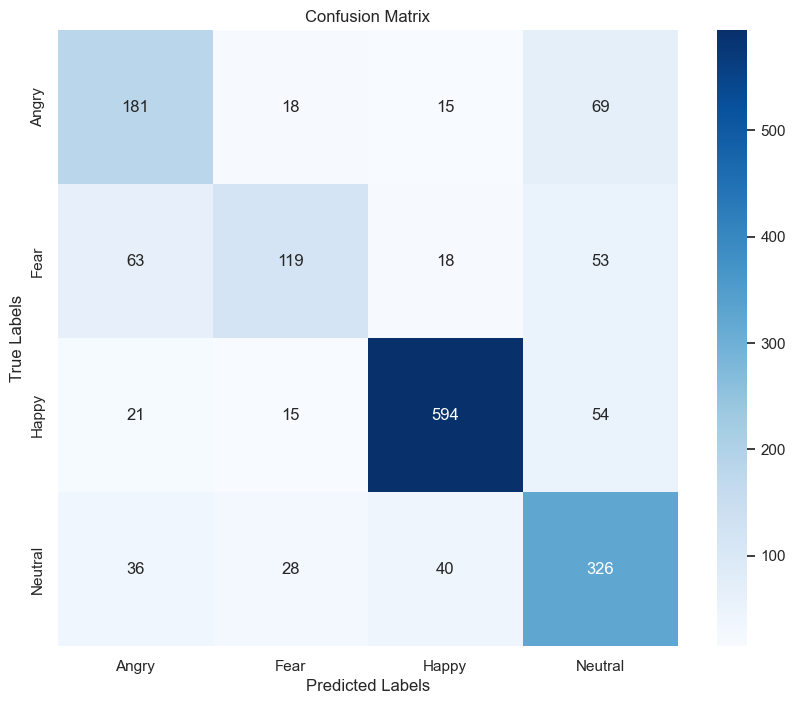

Test Accuracy: 73.94%


In [37]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Define the label_to_text dictionary
label_to_text = {0: 'Angry', 1: 'fear', 2: 'Happy', 3: 'Neutral'}

# Modify the label for 'fear' to 'Fear'
label_to_text[1] = 'Fear'

# Predict classes on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Ensure predictions and true labels are aligned
assert len(y_true_classes) == len(y_pred_classes), "Mismatch between true labels and predictions"

# Classification Report
class_names = list(label_to_text.values())  # Get class names from the updated label_to_text
report = classification_report(y_true_classes, y_pred_classes, target_names=class_names, digits=4)

# Print the classification report
print("Classification Report:")
print(report)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix_mobilenet.png', dpi=300)  # Save with higher DPI
plt.show()

# Overall Accuracy
accuracy = accuracy_score(y_true_classes, y_pred_classes)
print("Test Accuracy: {:.2f}%".format(accuracy * 100))

52/52 [==============================] - 1s 10ms/step
Classification Report:
              precision    recall  f1-score   support

       Angry     0.5680    0.6643    0.6124       283
        Fear     0.6474    0.4862    0.5553       253
       Happy     0.9112    0.8553    0.8824       684
     Neutral     0.6653    0.7535    0.7067       430

    accuracy                         0.7394      1650
   macro avg     0.6980    0.6898    0.6892      1650
weighted avg     0.7478    0.7394    0.7401      1650

Confusion Matrix:
[[188  25  12  58]
 [ 66 123  14  50]
 [ 27  17 585  55]
 [ 50  25  31 324]]


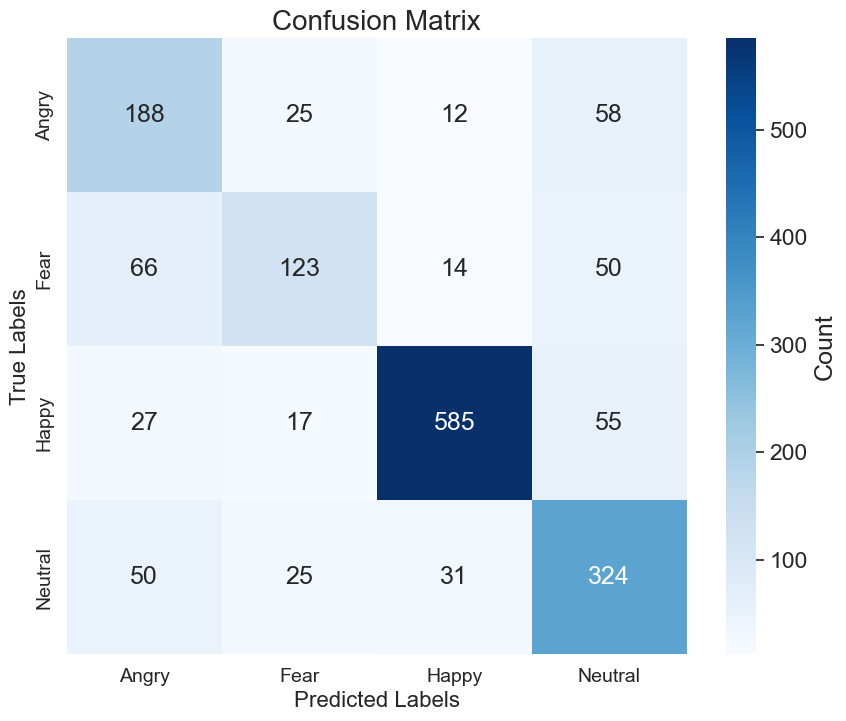

Test Accuracy: 73.94%


In [24]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Define the label_to_text dictionary
label_to_text = {0: 'Angry', 1: 'fear', 2: 'Happy', 3: 'Neutral'}

# Modify the label for 'fear' to 'Fear'
label_to_text[1] = 'Fear'

# Predict classes on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Ensure predictions and true labels are aligned
assert len(y_true_classes) == len(y_pred_classes), "Mismatch between true labels and predictions"

# Classification Report
class_names = list(label_to_text.values())  # Get class names from the updated label_to_text
report = classification_report(y_true_classes, y_pred_classes, target_names=class_names, digits=4)

# Print the classification report
print("Classification Report:")
print(report)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Increase the font size
sns.set(font_scale=1.5)  # Adjust this value as needed

# Plot the confusion matrix with increased font size
plt.figure(figsize=(10, 8))
ax = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, cbar_kws={'label': 'Count'})

# Set font sizes for the labels and title
plt.ylabel('True Labels', fontsize=16)
plt.xlabel('Predicted Labels', fontsize=16)
plt.title('Confusion Matrix', fontsize=20)

# Adjust tick label sizes
ax.tick_params(labelsize=14)

# Save the confusion matrix plot with higher DPI
plt.savefig('confusion_matrix_mobilenet2_l2.png', dpi=300)
plt.show()

# Overall Accuracy
accuracy = accuracy_score(y_true_classes, y_pred_classes)
print("Test Accuracy: {:.2f}%".format(accuracy * 100))


52/52 [==============================] - 0s 7ms/step


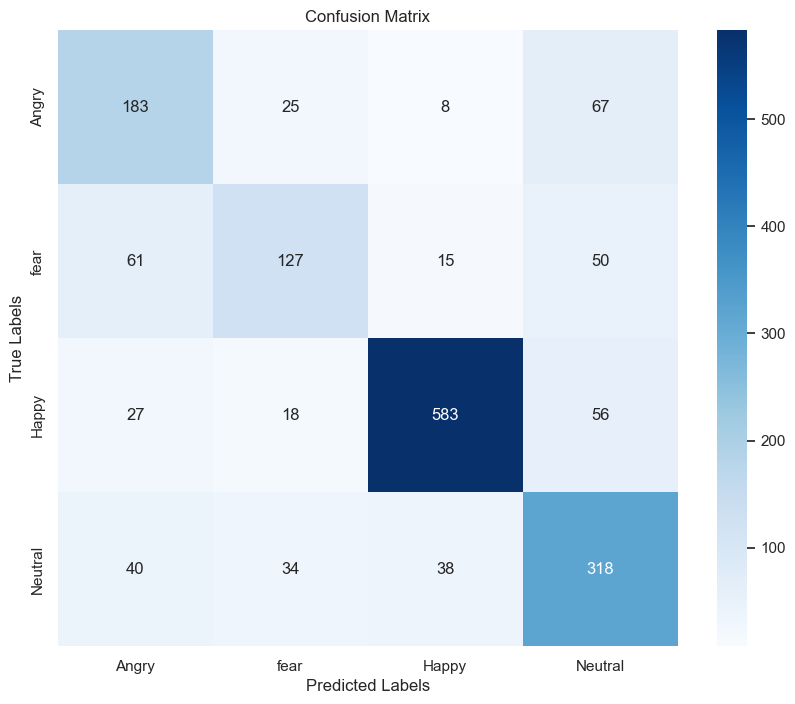

Classification Report:
               precision    recall  f1-score   support

       Angry       0.59      0.65      0.62       283
        fear       0.62      0.50      0.56       253
       Happy       0.91      0.85      0.88       684
     Neutral       0.65      0.74      0.69       430

    accuracy                           0.73      1650
   macro avg       0.69      0.69      0.69      1650
weighted avg       0.74      0.73      0.73      1650

Test accuracy: 73.39%


In [30]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from matplotlib import pyplot as plt
import seaborn as sns

# Predict classes on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Confusion Matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_to_text.values(), yticklabels=label_to_text.values())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix_mobilenet.png')
plt.show()

# Classification Report
class_report = classification_report(y_true_classes, y_pred_classes, target_names=label_to_text.values())
print("Classification Report:\n", class_report)

# Overall Accuracy
accuracy = accuracy_score(y_true_classes, y_pred_classes)
print("Test accuracy: {:.2f}%".format(accuracy * 100))


1/1 [==============================] - 0s 31ms/step


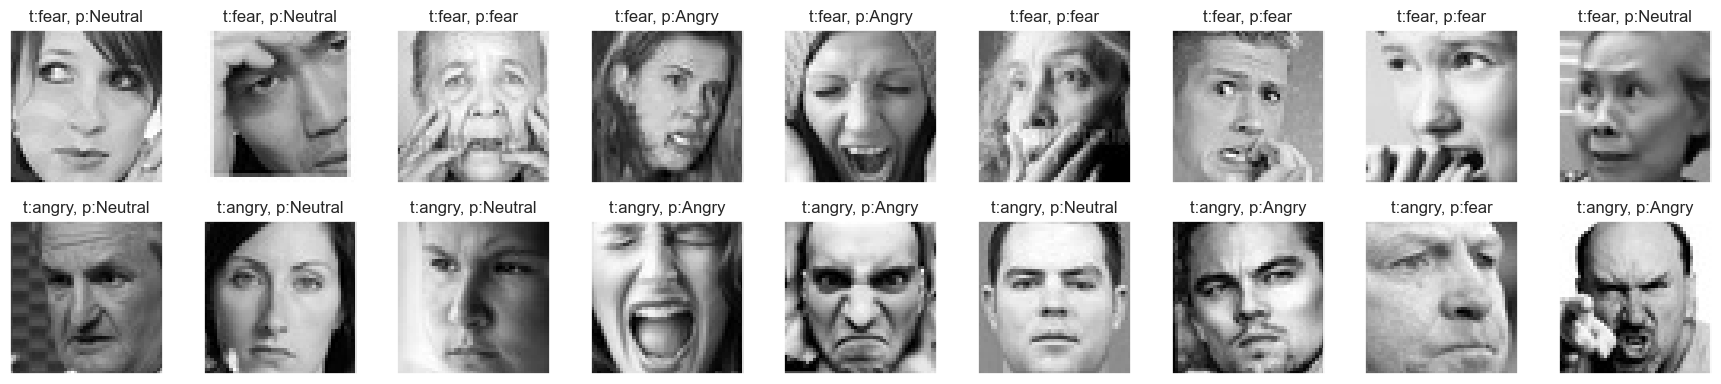

In [35]:
np.random.seed(42)
fear_imgs = np.random.choice(np.where(y_test[:, text_to_label["fear"]]==1)[0], size=9, replace=False)
angry_imgs = np.random.choice(np.where(y_test[:, text_to_label["Angry"]]==1)[0], size=9, replace=False)

fig = pyplot.figure(1, (18, 4))

for i, (fear_idx, angry_idx) in enumerate(zip(fear_imgs, angry_imgs)):
        sample_img = X_test[fear_idx,:,:,:]
        sample_img = sample_img.reshape(1,*sample_img.shape)
        pred = label_to_text[np.argmax(model.predict(sample_img), axis=1)[0]]

        ax = pyplot.subplot(2, 9, i+1)
        ax.imshow(sample_img[0,:,:,0], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"t:fear, p:{pred}")

        sample_img = X_test[angry_idx,:,:,:]
        sample_img = sample_img.reshape(1,*sample_img.shape)
        pred = label_to_text[np.argmax(model.predict(sample_img), axis=1)[0]]

        ax = pyplot.subplot(2, 9, i+10)
        ax.imshow(sample_img[0,:,:,0], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"t:angry, p:{pred}")

        pyplot.tight_layout()

In [36]:
def plot_miss_classified(emotion):
    miss_happy_indices = np.where((ytest_ != yhat_test) & (ytest_==text_to_label[emotion]))[0]
    print(f"total {len(miss_happy_indices)} miss labels out of {len(np.where(ytest_==text_to_label[emotion])[0])} for emotion {emotion}")

    cols = 15
    rows = math.ceil(len(miss_happy_indices) / cols)
    fig = pyplot.figure(1, (20, rows * 2))

    for i,idx in enumerate(miss_happy_indices):
        sample_img = X_test[idx,:,:,:]
        sample_img = sample_img.reshape(1,*sample_img.shape)
        pred = label_to_text[np.argmax(model.predict(sample_img), axis=1)[0]]

        ax = pyplot.subplot(rows,cols,i+1)
        ax.imshow(sample_img[0,:,:,0], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"p:{pred}")    

total 101 miss labels out of 684 for emotion Happy
1/1 [==============================] - 0s 16ms/step


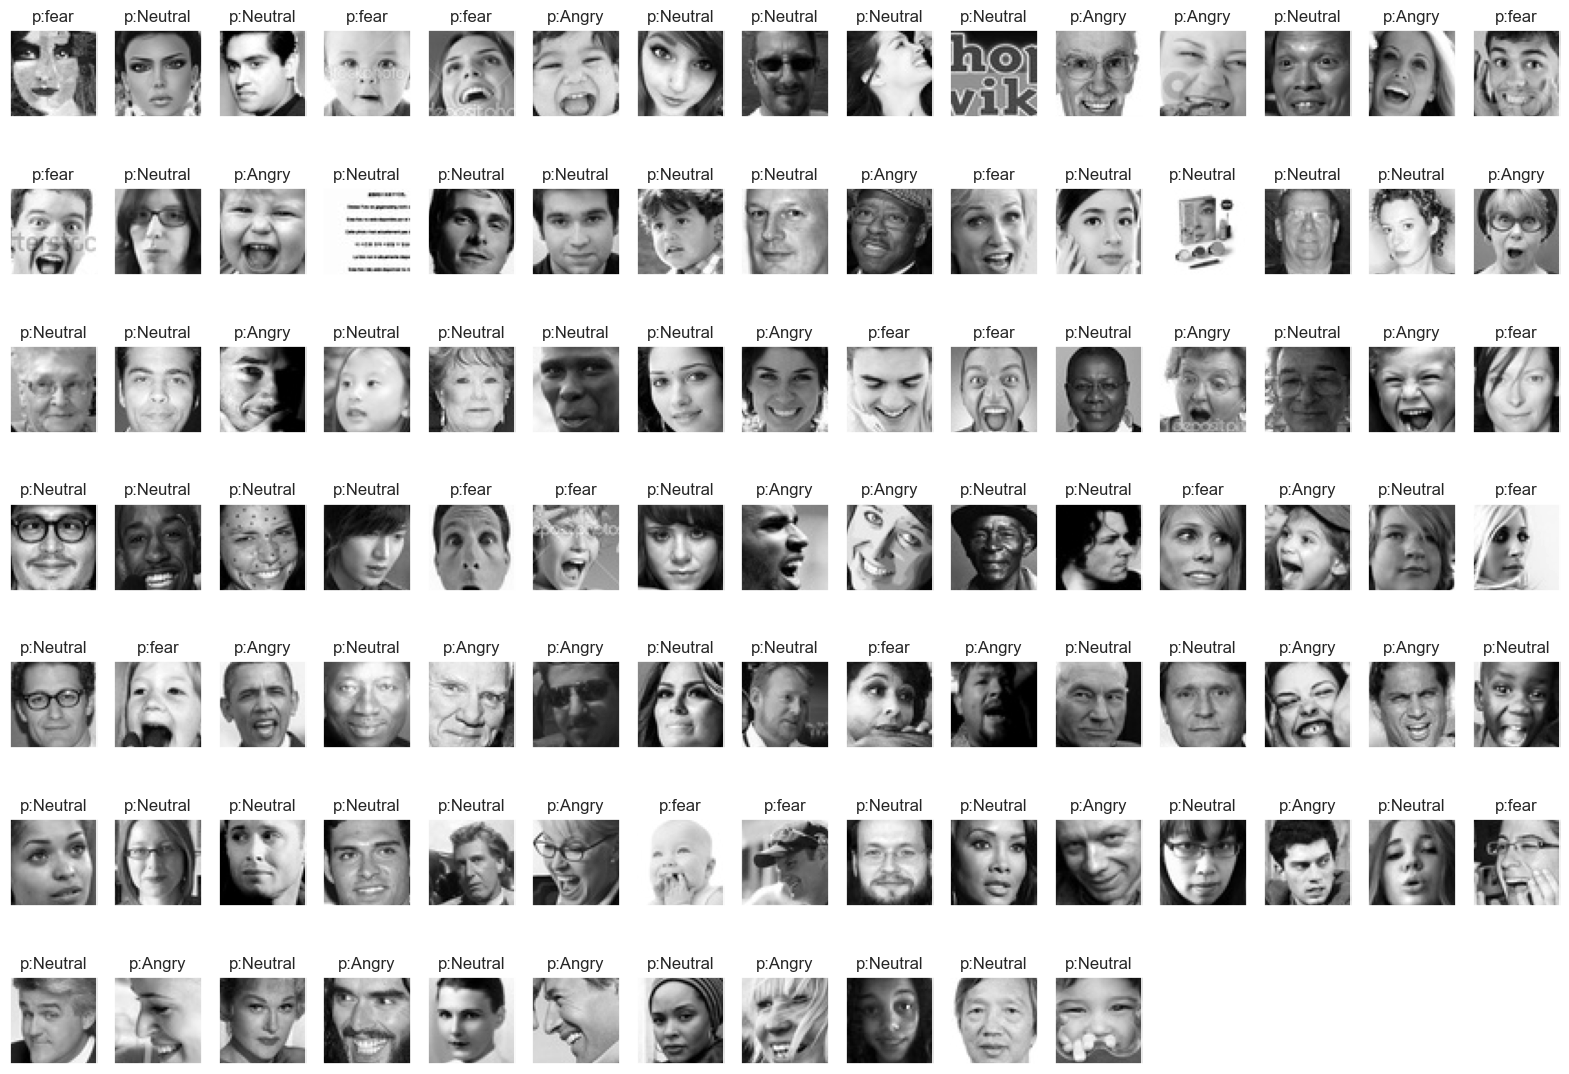

In [37]:
plot_miss_classified(emotion="Happy")

total 126 miss labels out of 253 for emotion fear
1/1 [==============================] - 0s 29ms/step


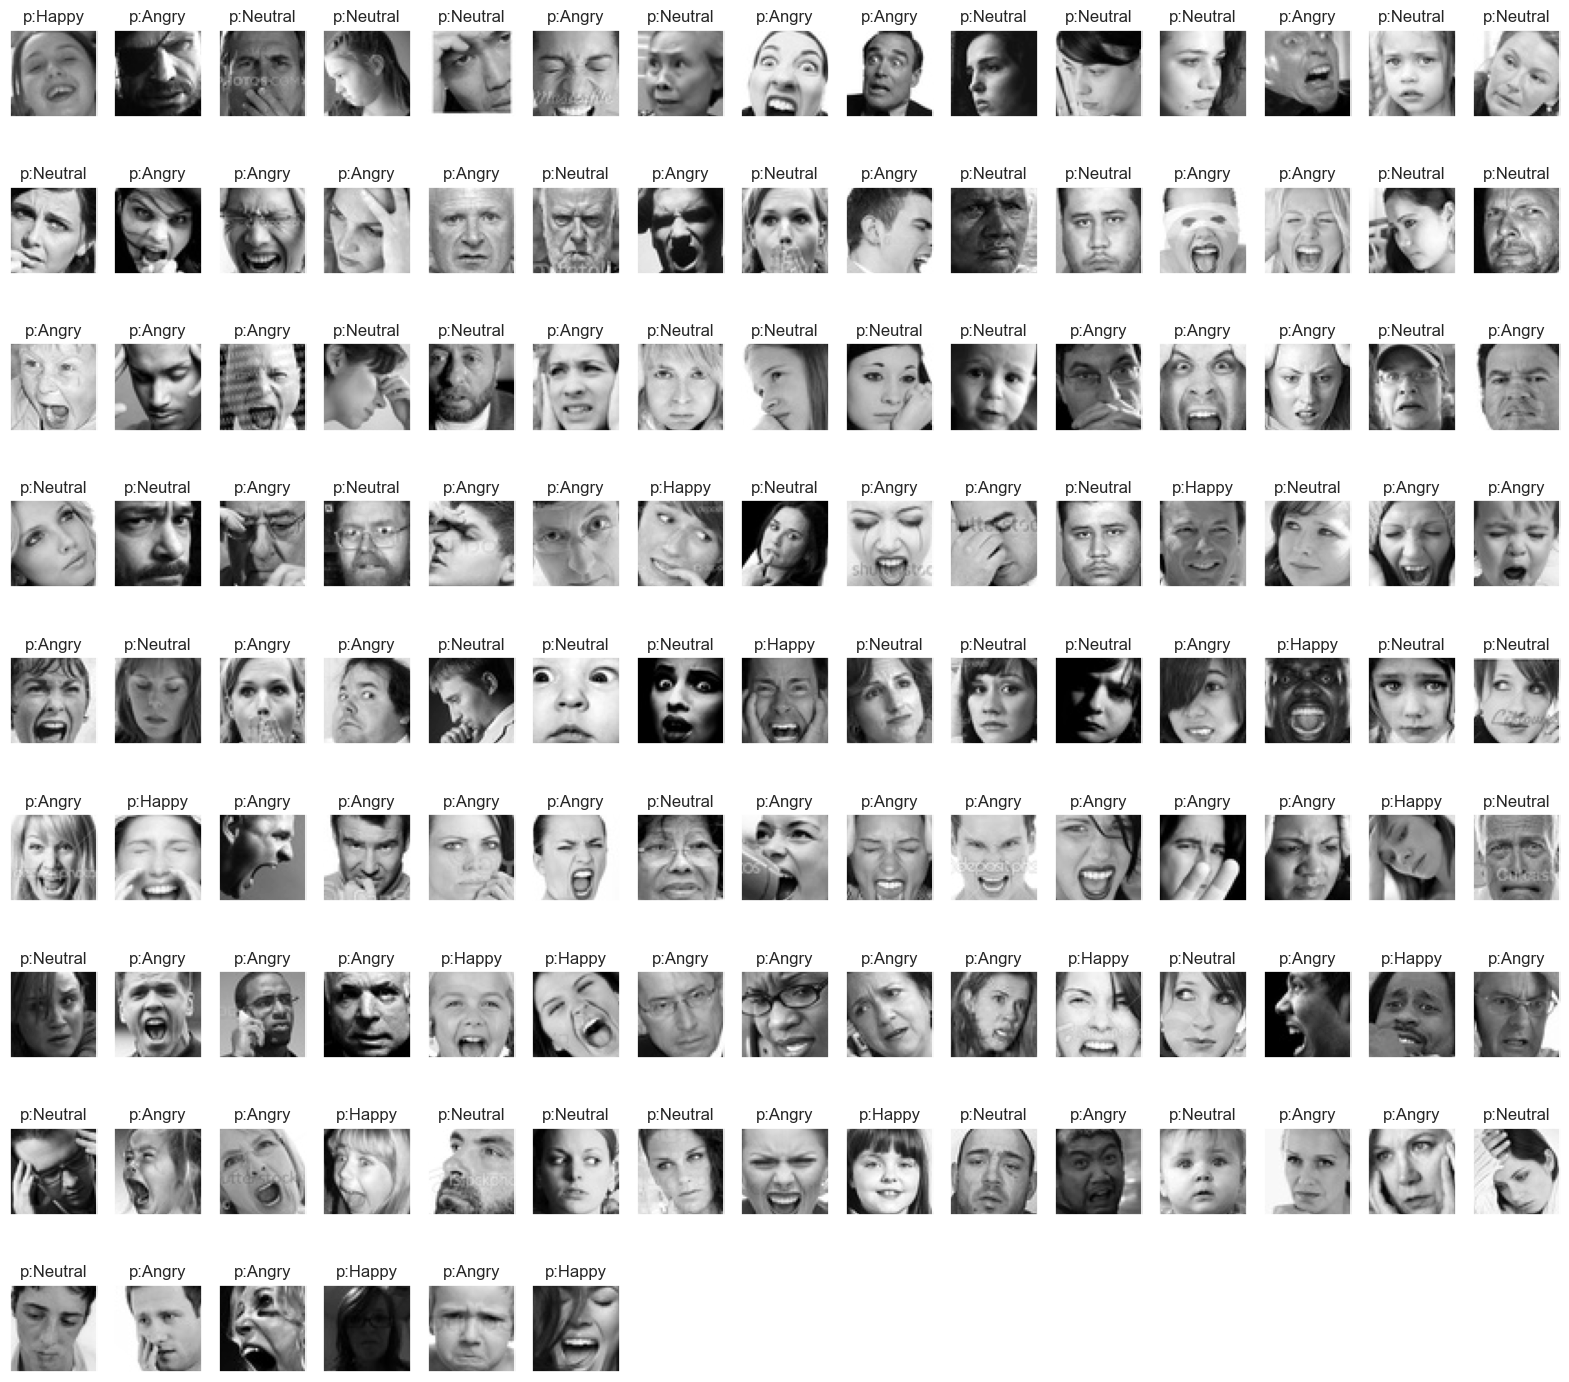

In [38]:
plot_miss_classified(emotion="fear")

total 100 miss labels out of 283 for emotion Angry
1/1 [==============================] - 0s 28ms/step


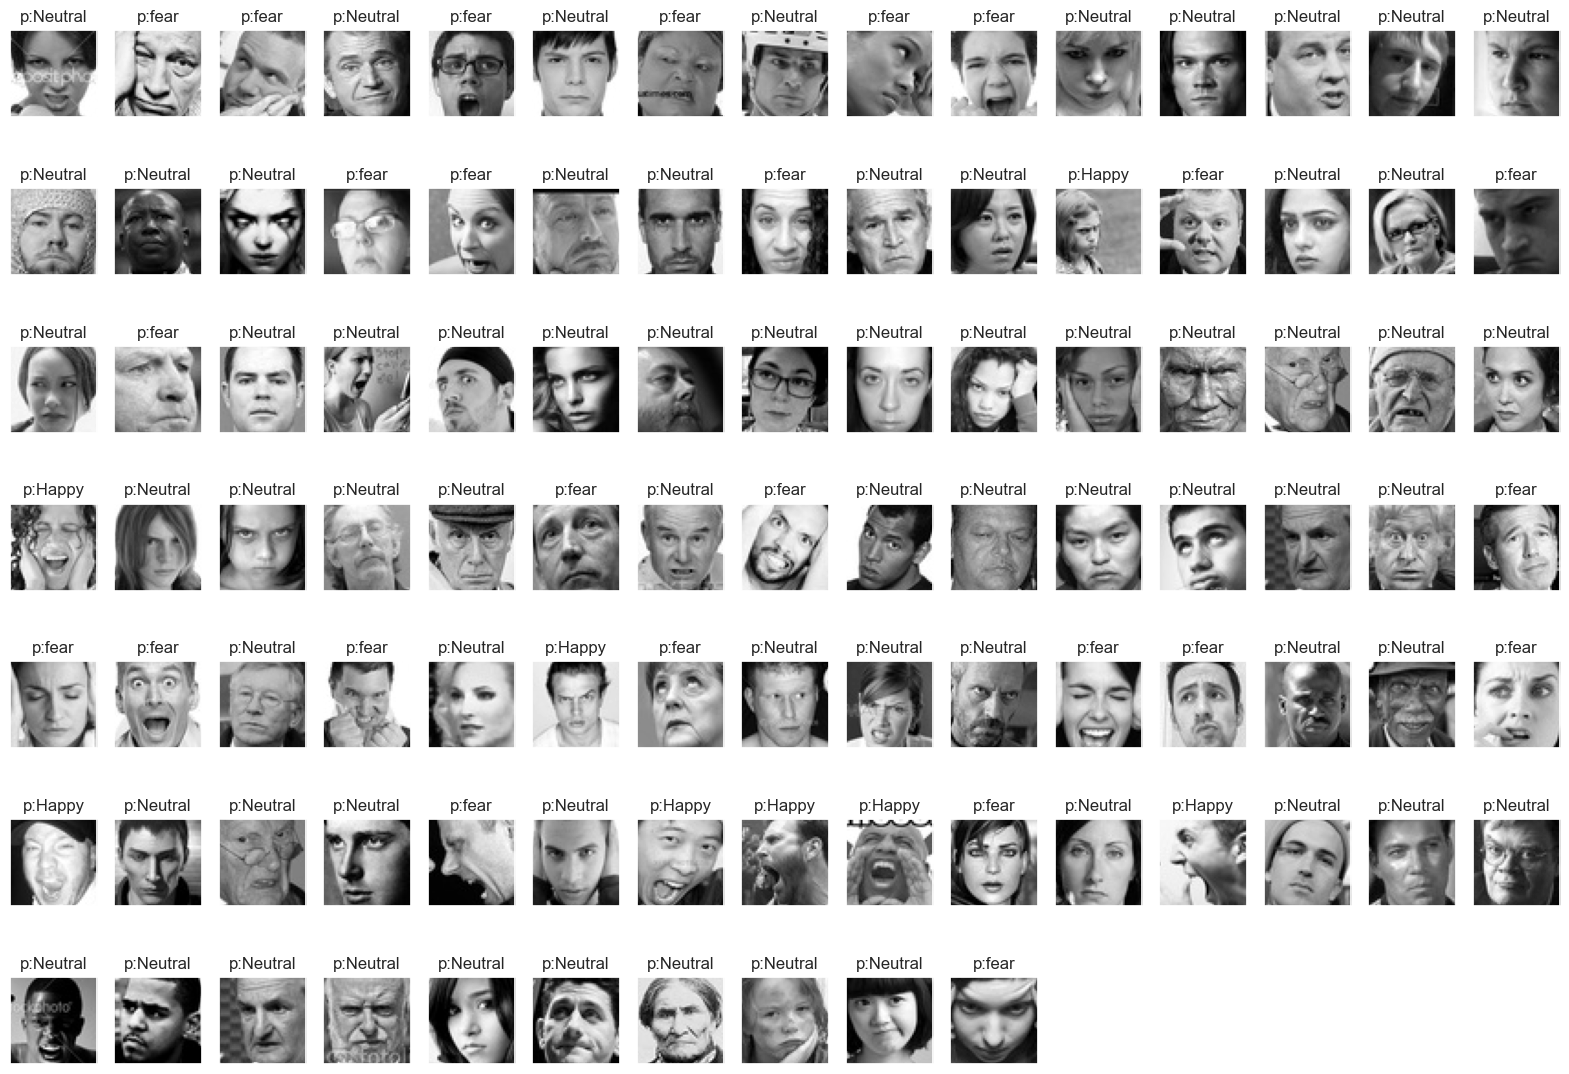

In [39]:
plot_miss_classified(emotion="Angry")

total 112 miss labels out of 430 for emotion Neutral
1/1 [==============================] - 0s 31ms/step


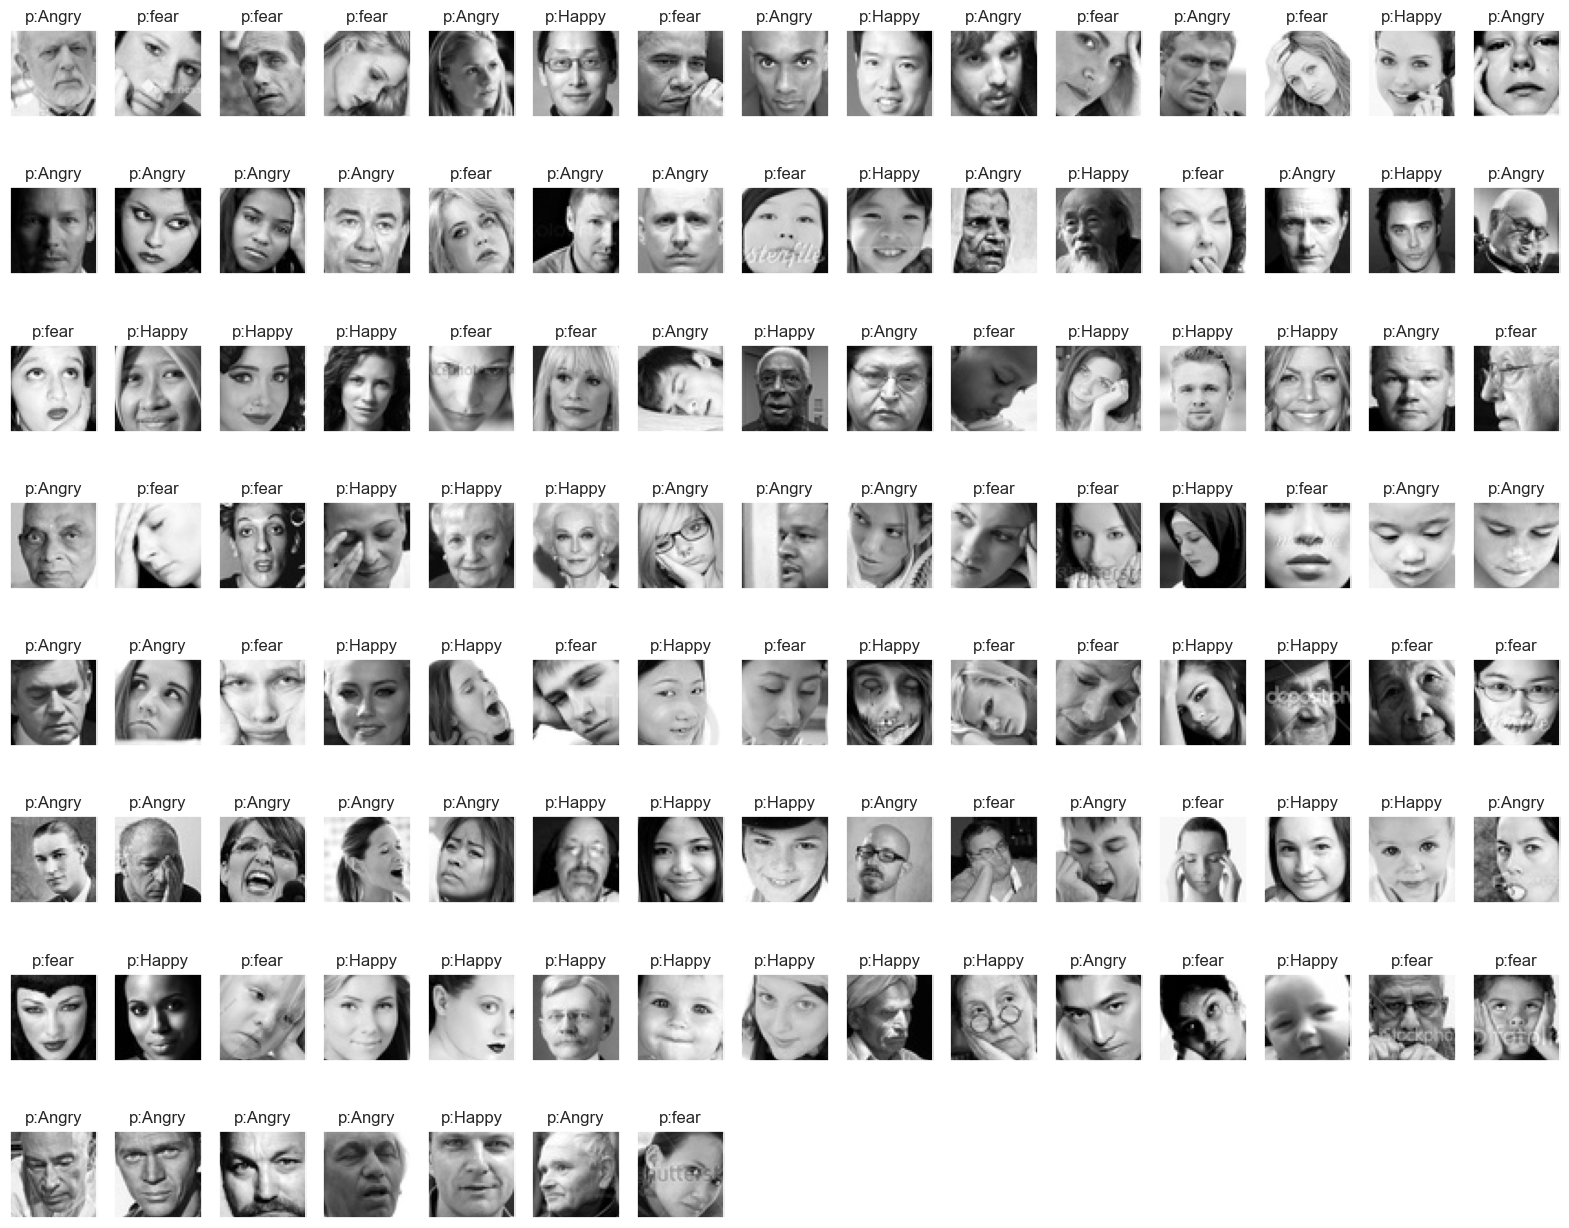

In [40]:
plot_miss_classified(emotion="Neutral")